# 文書生成AIのファインチューニング・レシピ
本Notebookでは、RLHFによりファインチューニングしたモデルを評価するコードを記載します。

## 応用レシピ：独自の報酬モデルでファインチューニングしたモデルの評価

### (1) ライブラリのインストール
利用するライブラリをインストールします。

In [1]:
%pip install transformers==4.35.2
%pip install trl[peft]==0.7.10
%pip install wandb==0.16.2
%pip install sentencepiece==0.1.99
%pip install accelerate==0.26.1
%pip install bitsandbytes==0.42.0
%pip install datasets==2.16.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 77.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.7/105.7 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━

### (2) ライブラリのインポート

In [2]:
import torch
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

tqdm.pandas()

from transformers import (pipeline, AutoTokenizer,
                          AutoModelForSequenceClassification)
from transformers import AutoModelForCausalLM
from datasets import load_dataset
from peft import LoraConfig
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


### (3) モデル名とデータセット名の定義

In [3]:
rm1_name = 'Mizuiro-sakura/luke-japanese-base-marcja'
rm2_name = 'taku-yoshioka/reward-model-0828'
base_model_name_for_reward = 'rinna/japanese-gpt2-medium'
model1_name = 'line-corporation/japanese-large-lm-1.7b'
model2_name = 'taku-yoshioka/rlhf-llm-custom-rm-0828'
dataset_name, subset_name = 'shunk031/JGLUE', 'MARC-ja'

### (4) 報酬モデルの読み込み
報酬モデル自体の比較のため、`2-3_train-reward-model.ipynb`で訓練した報酬モデルをロードします。

In [4]:
device = 0
sentiment_pipe1 = pipeline("sentiment-analysis", model=rm1_name, device=device)
sentiment_pipe2 = pipeline("sentiment-analysis",
                           model=AutoModelForSequenceClassification.from_pretrained(rm2_name, num_labels=1),
                           tokenizer=AutoTokenizer.from_pretrained("rinna/japanese-gpt2-medium"),
                           device=device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/937 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/842k [00:00<?, ?B/s]

entity_vocab.json:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/664 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/799 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at rinna/japanese-gpt2-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/806k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/153 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


### (5) 2つの報酬モデルの比較

In [5]:
def calc_rewards(dataset, sentiment_pipe1, sentiment_pipe2):
    reward1 = []
    reward2 = []

    for i, text in enumerate(tqdm(dataset)):
        r1 = sentiment_pipe1(text["review"], return_all_scores=True)[0][0]["score"]
        r2 = sentiment_pipe2(text["review"], return_all_scores=True)[0][0]["score"]
        reward1.append(r1)
        reward2.append(r2)
        if i > 1000:
            break

    df = pd.DataFrame({"reward1": reward1, "reward2": reward2})
    return df

In [6]:
sentiment_pipe2 = pipeline("sentiment-analysis",
                           model=AutoModelForSequenceClassification.from_pretrained(rm2_name, num_labels=1),
                           tokenizer=AutoTokenizer.from_pretrained(base_model_name_for_reward),
                           device=device)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at rinna/japanese-gpt2-medium and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for shunk031/JGLUE contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/shunk031/JGLUE
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


/root/.cache/huggingface/modules/datasets_modules/datasets/shunk031--JGLUE/bef660b0971cf102c95d2554bd2552ce5fb1cf8e9223cc6f8001c70be571c18c/JGLUE.py:464: UserWarning: can't import `mojimoji`, failing back to method that do nothing. We recommend running `pip install mojimoji` to reproduce the original preprocessing.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/187528 [00:00<?, ? examples/s]

  0%|          | 0/71819 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
  0%|          | 10/71819 [00:01<1:59:14, 10.04it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  1%|▏         | 1001/71819 [00:40<48:15, 24.46it/s]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

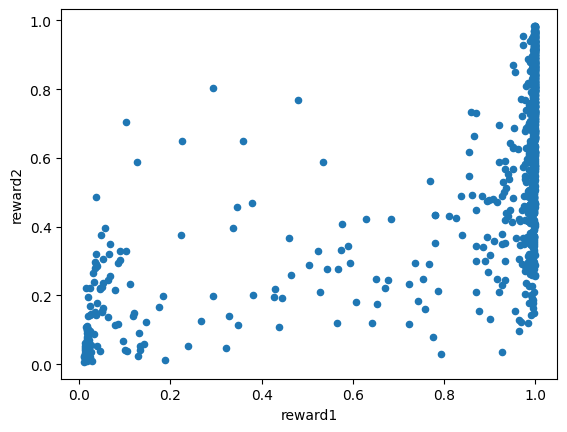

In [7]:
# データセットをロード、長さが200以上のサンプルを残す
ds = load_dataset(dataset_name, split="train", name=subset_name)
ds = ds.rename_columns({"sentence": "review"})
ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

df_ = calc_rewards(ds, sentiment_pipe1, sentiment_pipe2)
df_.plot.scatter("reward1", "reward2")
plt

### (6) ファインチューニング済みモデルの読み込み

In [8]:
pipe1 = pipeline('text-generation',
                 model=AutoModelForCausalLM.from_pretrained(model1_name),
                 tokenizer=AutoTokenizer.from_pretrained(model1_name)
                 )
pipe2 = pipeline('text-generation',
                 model=AutoModelForCausalLM.from_pretrained(model2_name),
                 tokenizer=AutoTokenizer.from_pretrained(model2_name)
                 )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

adapter_config.json:   0%|          | 0.00/650 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

### (7) 推論
推論の対象となるデータセットをロードします。

In [9]:
def build_dataset(model_name, dataset_name, subset_name=None, split="train",
                  input_min_text_length=2, input_max_text_length=8):
    # トーカナイザをロード
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    # データセットをロード、長さが200以上のサンプルを残す
    ds = load_dataset(dataset_name, split=split, name=subset_name,
                      trust_remote_code=True)
    ds = ds.rename_columns({"sentence": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    # 各サンプルの長さをランダムに選ぶ
    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    # 入力サンプルに対して長さをランダムに選び、トークン列に変換
    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")

    return ds

In [10]:
dataset = build_dataset(model1_name, dataset_name, subset_name=subset_name,
                        split="train")

Filter:   0%|          | 0/187528 [00:00<?, ? examples/s]

Map:   0%|          | 0/71819 [00:00<?, ? examples/s]

In [11]:
dataset.to_pandas().head()

,review,label,review_id,input_ids,query
0,以前職場の方にこれをみて少しでも元氣になってくださいと手渡して、早３年。返してくれと一度言っ...,0,R2H83XHJUDZBHT,"[4964, 3752]",以前職場
1,ジュリアロバーツを初めて見たのがこの作品だったということは良かったのか悪かったのかわからない...,0,R3FRTU63ITKFKB,"[263, 37057, 759]",ジュリアロ
2,自殺志願者おじ、ヤクチューの祖父、引きこもり息子、破綻した父、 それを必死にまともてようとす...,0,R1X34GVUNQQKPX,"[263, 33466, 44853, 496]",自殺志願者
3,大好きなＰＳＢの中でも１番好きなアルバムです。メロディラインの完成度，テクノを基本としながら...,0,R3A8Y91SEX0F2O,"[263, 4984, 3104, 404, 3831, 268, 807]",大好きなPSBの中でも1番
4,独特の世界は、男たちの挽歌時代から変わらない。登場人物（主役に偏る）の感情表現に重点を置き...,0,R38YCK808K11SG,"[263, 7907]",独特の


推論結果を評価するための関数を定義します。

In [12]:
def evaluate(dataset, pipe1, pipe2, sentiment_pipe):
    reward1 = []
    reward2 = []
    text1 = []
    text2 = []

    for i, text in tqdm(enumerate(dataset)):
        out1 = pipe1(text["query"], do_sample=False,
                    pad_token_id=pipe1.tokenizer.pad_token_id)
        out2 = pipe2(text["query"], do_sample=False,
                    pad_token_id=pipe2.tokenizer.pad_token_id)
        t1 = out1[0]["generated_text"]
        t2 = out2[0]["generated_text"]
        r1 = sentiment_pipe(t1, return_all_scores=True)[0][0]["score"]
        r2 = sentiment_pipe(t2, return_all_scores=True)[0][0]["score"]
        reward1.append(r1)
        reward2.append(r2)
        text1.append(t1)
        text2.append(t2)
        if i > 100:
            break

    df = pd.DataFrame({"reward1": reward1, "reward2": reward2,
                       "text1": text1, "text2": text2})
    return df


評価結果をデータフレームに格納します。

In [13]:
df = evaluate(dataset, pipe1, pipe2, sentiment_pipe1)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
101it [07:30,  4.46s/it]


### (8) 結果の確認

In [14]:
df.head()

,reward1,reward2,text1,text2
0,0.970281,0.993407,以前職場が一緒だった人が、 10月1日に、 10年勤めた,以前職場が一緒で、今でも仲良くしてもらっていて、とっても素敵な方なので、とってもとってもとっ...
1,0.860346,0.996149,ジュリアロバーツ 2012-09-29 12:0,ジュリアロバーツさん、とっても素敵で、かっこよくて、優しくて、面白くて、本当にかっこよくて
2,0.769809,0.969562,自殺志願者 2018-09-24 19:0,自殺志願者や、自殺を望んでいる人たちを、勇気づけ、勇気づけることで、自殺
3,0.998600,0.998451,大好きなPSBの中でも1番好きなアルバムです。 1曲目の「Something,大好きなPSBの中でも1番好きなアルバムで、今でもライブで聴くととても楽しく、ライブ
4,0.993457,0.996360,独特の香りと味わいが、 クセになる美味しさです。 100g 1,独特の存在感があり、とても存在感があり、存在感がありながらもとても可愛く、とても可愛く、とて...


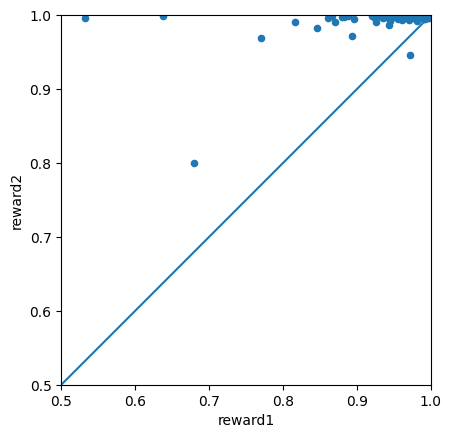

In [15]:
df.plot.scatter("reward1", "reward2")
plt.plot([0, 1], [0, 1])
plt.xlim([0.5, 1])
plt.ylim([0.5, 1])
plt.gca().set_aspect("equal")

In [16]:
df[["text1", "text2"]]

,text1,text2
0,以前職場が一緒だった人が、 10月1日に、 10年勤めた,以前職場が一緒で、今でも仲良くしてもらっていて、とっても素敵な方なので、とってもとってもとっ...
1,ジュリアロバーツ 2012-09-29 12:0,ジュリアロバーツさん、とっても素敵で、かっこよくて、優しくて、面白くて、本当にかっこよくて
2,自殺志願者 2018-09-24 19:0,自殺志願者や、自殺を望んでいる人たちを、勇気づけ、勇気づけることで、自殺
3,大好きなPSBの中でも1番好きなアルバムです。 1曲目の「Something,大好きなPSBの中でも1番好きなアルバムで、今でもライブで聴くととても楽しく、ライブ
4,独特の香りと味わいが、 クセになる美味しさです。 100g 1,独特の存在感があり、とても存在感があり、存在感がありながらもとても可愛く、とても可愛く、とて...
...,...,...
97,発売当時に初回版を予約し、発売日に購入したのですが、<0x0A>その後、通常版が,発売当時に初回入荷したカラーを再入荷!男女問わずお使いいただけるデザインで、様々なシーンで活...
98,コメディーで1話が30分と短いので、気軽に観られる。 1話,コメディーで1話が30分と短く、とても楽しく、あっという間に終わってしまうので、とても
99,このアルバムはすごい。ある意味、このアルバムは、 1970年代、80,このアルバムはすごい。ある意味、圧巻。ライブならではの迫力と楽しさが凝縮されていて、ライブな...
100,すごく楽しみにバイオ3をプレイしています。 バイオ3は、バイオシリーズの中でも、 最も難易度,すごく楽しみにバイオ3をプレイしています。とても楽しく、とてもやりがいがあり、とても美しく、...


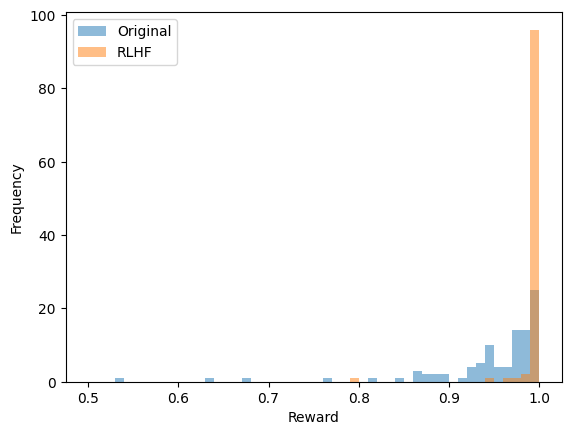

In [17]:
df["reward1"].hist(range=(0.5, 1), bins=50, alpha=0.5, label="Original")
df["reward2"].hist(range=(0.5, 1), bins=50, alpha=0.5, label="RLHF")
plt.gca().grid(False)
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.legend()

In [18]:
df[df["reward1"] < 0.9][["text1", "text2"]]

,text1,text2
1,ジュリアロバーツ 2012-09-29 12:0,ジュリアロバーツさん、とっても素敵で、かっこよくて、優しくて、面白くて、本当にかっこよくて
2,自殺志願者 2018-09-24 19:0,自殺志願者や、自殺を望んでいる人たちを、勇気づけ、勇気づけることで、自殺
8,観ているこちら側からすれば、 100%の満足は得られない。 100,観ているこちら側からすれば、とても楽しく、そして、とてもかっこよく、そして、とてもあたたかく、
9,ご存知の通り、 1000円札は、 1000円の価値,ご存知の通り、とても美しい音色で、演奏していてとても楽しく、また演奏していてとても楽しく、
15,オペラ座の怪人 2018-09-25 19,オペラ コンサートなど様々なシーンで活躍してくれます。 様々なシーンで活躍してくれる、とって...
22,19:00 ~ 21:00 19:00,1999年11月21日発売) 収録曲目など、ライブならではの
27,2012年09月29日(土) 0 | 0,2012年09月28日 16時00分0
30,~音楽をジャンルで分けることが無意味な理由~ 2018-09-,~音楽をジャンルで分けることがなく、音楽を通して、たくさんの人と出会い、音楽を通して、たくさんの
35,トロッコ列車 トロッコ列車 トロッコ列車 トロッコ列車 トロッコ列車,トロッとしていて、とても美味しく、家族みんなとても喜んでいます。またぜひ購入させていただきた...
38,佐野元春 / 佐野元春 / 佐野元春 / 佐野,佐野元春さんのライブは、本当に素晴らしく、音楽の素晴らしさを、音楽を通して、たくさんの方に
